# Count viral tags on aligned Illumina 10X reads
This Python Jupyter notebook counts the viral tags on aligned Illumina 10X data and outputs the counts of each viral tag variant for each cell barcode and gene into a CSV.

## Parameters for notebook
First, set the parameters for the notebook.
That should be done in the next cell, which is tagged as a `parameters` cell to enable [papermill parameterization](https://papermill.readthedocs.io/en/latest/usage-parameterize.html):

In [1]:
# parameters cell; in order for notebook to run this cell must define:
#  - input_fastq10x_bam: BAM file with aligned FASTQ 10X reads
#  - input_fastq10x_bai: BAM index file for `input_fastq10x_bai`
#  - input_viraltag_locs: CSV file giving the location of the viral tags
#  - input_viraltag_identities: YAML file giving expected identity of each tag for each tag variant
#  - input_cellbarcodes: TSV file giving valid cell barcodes
#  - output_viraltag_counts: created CSV file with the counts of each tag variant for each gene

In [2]:
from os.path import join

d = 'results/aligned_fastq10x'
s = 'wt_virus_pilot'

input_fastq10x_bam = join(d, s, 'Aligned.sortedByCoord.out.bam')
input_fastq10x_bai = input_fastq10x_bam + '.bai'
input_viraltag_locs = 'results/viral_fastq10x/viraltag_locs.csv'
input_viraltag_identities = 'data/flu_sequences/flu-CA09_viral_tags.yaml'
input_cellbarcodes = join(d, s, 'Solo.out/Gene/filtered/barcodes.tsv')
output_viraltag_counts = '_temp.csv'

## Import Python modules

In [3]:
import pandas as pd

from plotnine import *

from pymodules.tags_and_barcodes import extract_tags

import pysam

import yaml

## Read tags and expected identities

In [4]:
print(f"Reading expected tag identities from {input_viraltag_identities}")
with open(input_viraltag_identities) as f:
    viraltag_identities_dict = yaml.safe_load(f)

viraltag_identities_df = (
    pd.DataFrame.from_records(
        [(gene, tag, tagvariant, nt)
         for gene, genetags in viraltag_identities_dict.items()
         for tag, tagvals in genetags.items()
         for tagvariant, nt in tagvals.items()],
        columns=['gene', 'tag', 'tag_variant', 'nucleotide'])
    .pivot_table(index=['gene', 'tag'],
                  columns='tag_variant',
                  values='nucleotide',
                  aggfunc='sum')
    )

print('Here are the tag identities:')
viraltag_identities_df

Reading expected tag identities from data/flu_sequences/flu-CA09_viral_tags.yaml
Here are the tag identities:


tag_variant        syn wt
gene   tag               
fluHA  viral_tag_1   T  C
       viral_tag_2   C  T
fluM   viral_tag_1   A  G
       viral_tag_2   G  A
fluNA  viral_tag_1   A  G
       viral_tag_2   T  C
       viral_tag_3   T  C
       viral_tag_4   T  A
       viral_tag_5   C  G
       viral_tag_6   T  C
       viral_tag_7   T  C
       viral_tag_8   A  C
fluNP  viral_tag_1   T  C
       viral_tag_2   G  A
fluNS  viral_tag_1   T  C
       viral_tag_2   A  C
fluPA  viral_tag_1   T  C
       viral_tag_2   T  C
fluPB1 viral_tag_1   A  G
       viral_tag_2   A  G
fluPB2 viral_tag_1   G  A
       viral_tag_2   A  G

Get tag variants and make sure an identity is defined for each tag variant at each tag:

In [5]:
tag_variants = viraltag_identities_df.columns.tolist()
print(f"Here are the {len(tag_variants)} tag variants: {', '.join(tag_variants)}")

assert viraltag_identities_df.notnull().any(axis=None), 'identities missing for some tags'

Here are the 2 tag variants: syn, wt


Read the viral tag locations:

In [6]:
print(f"Reading viral tag locations from {input_viraltag_locs}")
viraltag_locs_df = pd.read_csv(input_viraltag_locs)
viraltag_locs_df

Reading viral tag locations from results/viral_fastq10x/viraltag_locs.csv


,gene,tag_name,start,end
0,fluPB2,viral_tag_1,201,201
1,fluPB2,viral_tag_2,2190,2190
2,fluPB1,viral_tag_1,192,192
3,fluPB1,viral_tag_2,2205,2205
4,fluPA,viral_tag_1,123,123
5,fluPA,viral_tag_2,2104,2104
6,fluHA,viral_tag_1,249,249
7,fluHA,viral_tag_2,1686,1686
8,fluNP,viral_tag_1,132,132
9,fluNP,viral_tag_2,1407,1407


Make sure we have locations and tag identities for same genes:

In [7]:
tagged_viral_genes = viraltag_locs_df['gene'].unique()
assert set(tagged_viral_genes) == set(viraltag_identities_dict)

And that for each viral gene we have the same set of tags:

In [8]:
for gene in tagged_viral_genes:
    if (set(viraltag_locs_df.query('gene == @gene')['tag_name']) != set(viraltag_identities_dict[gene])):
        raise ValueError(f"inconsistent tags for {gene}")

## Get set of valid cell barcodes

In [9]:
print(f"Reading vaid cell barcodes from {input_cellbarcodes}")

cellbarcodes = set(pd.read_csv(input_cellbarcodes, header=None)[0])

print(f"Read {len(cellbarcodes)} valid barcodes.")

Reading vaid cell barcodes from results/aligned_fastq10x/wt_virus_pilot/Solo.out/Gene/filtered/barcodes.tsv
Read 3607 valid barcodes.


## Count viral tags
For each cell barcode and each viral gene, we count the number of unique reads for each viral tag variant.

The basic process is as follows:
 1. For each viral tag, parse the tag identity for all reads that cover that tag.
    The reads are grouped by UMI and cell barcode, and the tag is labeled as `ambiguous` if no tag identities compose more than 50% of the reads for a UMI in a cell.
 2. The tags are then assigned to their tag variants, labeling the tag variant as `invalid` if the identity at the tag doesn't belong to an expected tag variant.
 3. Unify the tag assigments across tags by looking for UMIs that have several tags covered.
    If all of the tags agree on the tag variant, then that's what we assign that UMI.
    If the tags disagree, label as `tags_disagree`.
    
The output of this process is the tidy data frame `tag_variant_counts`:

In [10]:
print(f"Parsing reads from {input_fastq10x_bam} (index {input_fastq10x_bai}):\n")

with pysam.AlignmentFile(input_fastq10x_bam, index_filename=input_fastq10x_bai) as bamfile:
    
    tag_variant_counts = pd.DataFrame({},
                                      columns=['gene', 'cell_barcode', 'tag_variant', 'count'])
    
    for gene in tagged_viral_genes:
        print(f"Processing tags for {gene}")
        
        # parse each tag for the gene
        counts_df = pd.DataFrame({}, columns=['cell_barcode', 'UMI', 'tag_variant'])
        for tup in viraltag_locs_df.query('gene == @gene').itertuples():
            tag_to_variant = {var: tag for tag, var in
                                  viraltag_identities_dict[gene][tup.tag_name].items()}
            tag_to_variant['ambiguous'] = 'ambiguous'
            readiterator = bamfile.fetch(contig=tup.gene,
                                         start=tup.start - 1,  # convert 1- to 0-based indexing
                                         end=tup.end,
                                         )
            tag_counts_df = (
                        extract_tags(readiterator, cellbarcodes, tup.start - 1, tup.end)
                        .assign(tag_variant=lambda x: (x['tag']
                                                       .map(tag_to_variant)
                                                       .fillna('invalid'))
                                 )
                        [['cell_barcode', 'UMI', 'tag_variant']]
                        )
            print(f"\tParsed tag {tup.tag_name} for {len(tag_counts_df)} UMIs.")
            counts_df = counts_df.append(tag_counts_df)
            
        # unify tag variant assignments across tags for gene
        tag_variant_counts = tag_variant_counts.append(
            counts_df
            .groupby(['cell_barcode', 'UMI'])
            .aggregate(tag_variant=pd.NamedAgg('tag_variant', 'first'),
                       n_tag_variants=pd.NamedAgg('tag_variant', 'nunique'))
            .reset_index()
            .groupby(['cell_barcode', 'tag_variant', 'n_tag_variants'])
            .aggregate(count=pd.NamedAgg('UMI', 'count'))
            .reset_index()
            .assign(tag_variant=lambda x: x['tag_variant'].where(x['n_tag_variants'] == 1,
                                                                 'tags disagree'),
                    gene=gene)
            [['gene', 'cell_barcode', 'tag_variant', 'count']],
            ignore_index=True, sort=False
            )     

Parsing reads from results/aligned_fastq10x/wt_virus_pilot/Aligned.sortedByCoord.out.bam (index results/aligned_fastq10x/wt_virus_pilot/Aligned.sortedByCoord.out.bam.bai):

Processing tags for fluPB2
	Parsed tag viral_tag_1 for 18 UMIs.
	Parsed tag viral_tag_2 for 481 UMIs.
Processing tags for fluPB1
	Parsed tag viral_tag_1 for 29 UMIs.
	Parsed tag viral_tag_2 for 996 UMIs.
Processing tags for fluPA
	Parsed tag viral_tag_1 for 20 UMIs.
	Parsed tag viral_tag_2 for 476 UMIs.
Processing tags for fluHA
	Parsed tag viral_tag_1 for 70 UMIs.
	Parsed tag viral_tag_2 for 24 UMIs.
Processing tags for fluNP
	Parsed tag viral_tag_1 for 6097 UMIs.
	Parsed tag viral_tag_2 for 12943 UMIs.
Processing tags for fluNA
	Parsed tag viral_tag_1 for 12 UMIs.
	Parsed tag viral_tag_2 for 134 UMIs.
	Parsed tag viral_tag_3 for 107 UMIs.
	Parsed tag viral_tag_4 for 107 UMIs.
	Parsed tag viral_tag_5 for 107 UMIs.
	Parsed tag viral_tag_6 for 107 UMIs.
	Parsed tag viral_tag_7 for 24 UMIs.
	Parsed tag viral_tag_8 for

The results are now in the data frame `tag_variant_counts`:

In [11]:
tag_variant_counts

,gene,cell_barcode,tag_variant,count
0,fluPB2,AAACGCTCACCGAATT,wt,5
1,fluPB2,AAAGGGCGTATTGGCT,wt,1
2,fluPB2,AAAGGTAGTCGTTTCC,wt,4
3,fluPB2,AAAGTGAAGGAGATAG,wt,2
4,fluPB2,AACAACCGTGCGAGTA,wt,1
...,...,...,...,...
4398,fluNS,TTTGGAGAGAGTCTGG,wt,2
4399,fluNS,TTTGGTTCATCCGAGC,wt,1
4400,fluNS,TTTGGTTGTAAGTAGT,wt,1
4401,fluNS,TTTGGTTTCTATCCAT,syn,1


## Summarize the viral tag counts
Get the total fraction of each tag variant for each gene across all cell barcodes:

In [12]:
tag_order = tag_variants + sorted(t for t in tag_variant_counts['tag_variant'].unique()
                                  if t not in tag_variants)

total_tag_variant_counts = (
    tag_variant_counts
    .groupby(['gene', 'tag_variant'])
    .aggregate({'count': 'sum'})
    .reset_index()
    .assign(gene=lambda x: pd.Categorical(x['gene'],
                                          tagged_viral_genes,
                                          ordered=True),
            tag_variant=lambda x: pd.Categorical(x['tag_variant'],
                                                 tag_order,
                                                 ordered=True,
                                                 ),
            total=lambda x: x.groupby('gene')['count'].transform('sum'),
            frac=lambda x: x['count'] / x['total'],
            valid_tag=lambda x: x['tag_variant'].isin(tag_variants)
            )
    )

(total_tag_variant_counts
 .pivot_table(index=['gene', 'total'],
              columns='tag_variant',
              values='frac',
              fill_value=0)
 .round(3)
 )

,tag_variant,syn,wt,ambiguous,invalid,tags disagree
gene,total,,,,,
fluPB2,499,0.002,0.998,0.0,0.000,0.000
fluPB1,1025,0.006,0.991,0.0,0.003,0.000
fluPA,496,0.000,0.996,0.0,0.004,0.000
fluHA,94,0.000,1.000,0.0,0.000,0.000
fluNP,19040,0.001,0.994,0.0,0.005,0.000
fluNA,178,0.006,0.972,0.0,0.006,0.017
fluM,26131,0.001,0.998,0.0,0.001,0.000
fluNS,21762,0.005,0.994,0.0,0.001,0.000


Plot number of UMIs with called viral tags for each gene:

/fh/fast/bloom_j/software/conda_v2/envs/BloomLab/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_bar : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


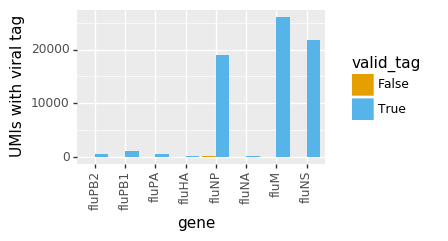

In [13]:
p = (ggplot(total_tag_variant_counts
            .groupby(['gene', 'valid_tag'])
            .aggregate({'count': 'sum'})
            .reset_index(),
            aes('gene', 'count', fill='valid_tag')) +
     geom_bar(stat='identity', position='dodge') +
     theme(figure_size=(0.4 *  len(tagged_viral_genes), 2),
           axis_text_x=element_text(angle=90)) +
     ylab('UMIs with viral tag') +
     scale_fill_manual(values=('#E69F00', '#56B4E9'))
     )
_ = p.draw()

Plot the fraction of called tags that go with each variant for each gene:

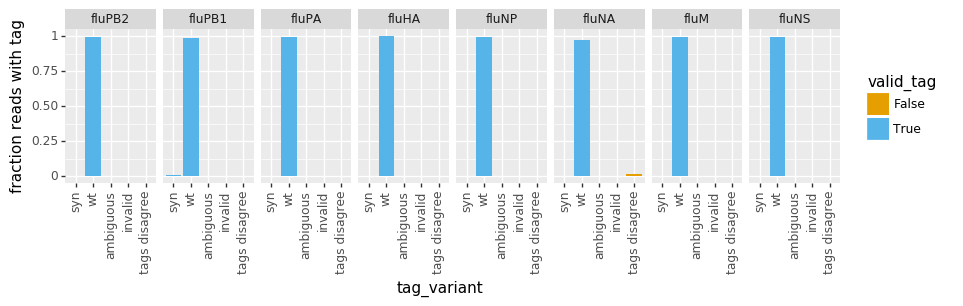

In [14]:
p = (ggplot(total_tag_variant_counts,
            aes('tag_variant', 'frac', fill='valid_tag')) +
     geom_bar(stat='identity') +
     facet_wrap('~ gene', nrow=1) +
     theme(figure_size=(1.25 * len(tagged_viral_genes), 2),
           axis_text_x=element_text(angle=90)) +
     ylab('fraction with tag') +
     scale_fill_manual(values=('#E69F00', '#56B4E9'))
     )
_ = p.draw()

## Write counts of valid viral tag variants
Finally, we write the counts of the valid viral tag variants to an output CSV file for later use.
Note that we **only** write non-zero counts for valid tags:

In [15]:
print(f"Writing counts to {output_viraltag_counts}")

(total_tag_variant_counts
 .query('valid_tag')
 [['gene', 'tag_variant', 'count']]
 .sort_values(['gene', 'tag_variant'])
 .to_csv(output_viraltag_counts, index=False)
 )

Writing counts to _temp.csv
